# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<span style="color: blue">Remove all blue text before submitting</span>

In [1]:
%matplotlib inline
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [2]:
verboseStatus = False

In [3]:
# Brett's directory
# Desktop
#%cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
# %cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory. Either uncomment the cd statement above or make your own cd.
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
%cd C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\MiniLab"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

print('********* Initial Values Before Cleaning *******************')
dfPublicHS.info(verbose = verboseStatus)

C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\MiniLab
********* Initial Values Before Cleaning *******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


## Data Reduction / Prep

In [6]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    scaler = StandardScaler()
    temp = scaler.fit_transform(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

In [7]:
param_grid = [ {'C': [1, 10, 100, 1000], 'kernel': ['linear']} ]
cls = GridSearchCV(SVC(), param_grid, cv=10)

In [8]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = 52
dfPublicHS['schoolPctTarget'] = np.where(dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)
print("{} of {}: {}%".format(dfPublicHS['schoolPctTarget'].sum(), dfPublicHS.shape[0], 
                             round(dfPublicHS['schoolPctTarget'].sum()/dfPublicHS.shape[0] * 100,2)))

239 of 470: 50.85%


In [9]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings

# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct|college')

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes'}

# Drop columns
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

In [10]:
# Credit: https://www.kaggle.com/saravanann/santander

# Normalize data
maxCols = dfPublicHS.shape[1]
X = scale_data(dfPublicHS.iloc[:,0:maxCols-2])

# Set target
y = dfPublicHS['schoolPctTarget']

In [11]:
# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

C:\Users\Nicole Wittlin\Anaconda3\envs\dataminingintro\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [20]:
dfPublicHS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 394 entries, student_num to unit_code
dtypes: float64(313), int64(81)
memory usage: 1.4 MB


## Logistic Regresion, using data set reduced by feature selection

In [12]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'schoolPctTarget' in dfPublicHS:
    y = dfPublicHS['schoolPctTarget'].values # get the labels we want
    del dfPublicHS['schoolPctTarget'] # get rid of the class label
    X = dfPublicHS.values # use everything else to predict!

## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
#    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [13]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.6914893617021277
confusion matrix
 [[34 13]
 [16 31]]
====Iteration 1  ====
accuracy 0.7021276595744681
confusion matrix
 [[29 12]
 [16 37]]
====Iteration 2  ====
accuracy 0.5957446808510638
confusion matrix
 [[26 17]
 [21 30]]


In [15]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[0.73404255 0.61702128 0.61702128]


In [16]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor(cost)>

## Interpret Weights

In [17]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=1, class_weight=None) # get object
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,dfPublicHS.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.7340425531914894
[[32 11]
 [14 37]]
GraduationRate_4yr_SWD has weight of -1.087638643785182
lea_advance_dgr_pct has weight of -1.003424010908016
pct_eds has weight of -0.7712359177539482
EOCEnglish2_GLP_SWD has weight of -0.7206874492162112
MathGr10_pTarget_PctMet has weight of -0.6859263701891224
st_total_specialized_courses has weight of -0.6793882562282751
ACTMath_ACTBenchmark_TwoorMoreRaces has weight of -0.6318834340545748
AsianMalePct has weight of -0.6290369561590738
12_Size has weight of -0.6043036306816882
lea_sat_participation_pct has weight of -0.6028251668456023
ACTSubtests_BenchmarksMet_EDS has weight of -0.5944578491735435
ACTReading_ACTBenchmark_Black has weight of -0.582828788618529
books_per_student has weight of -0.5660829790442796
GraduationRate_4yr_LEP has weight of -0.5626240697120918
wap_num has weight of -0.5586188690275319
ACTWorkKeys_SilverPlus_AmericanIndian has weight of -0.5581734643511553
TwoOrMoreFemalePct has weight of -0.5472904970558803
lea_

SPG_Grade_C has weight of 0.1328848319686694
GraduationRate_4yr_Black has weight of 0.13468617022948998
grades_1_to_1_access_10:11:12:13 has weight of 0.13921901826058705
SRC_Grades_Devices_Sent_Home_9:10:11:12 has weight of 0.14113071956649714
ACTMath_ACTBenchmark_Female has weight of 0.14195845610980393
Developing_TCHR_Standard_5_Pct has weight of 0.14307167183325487
esea_status_P has weight of 0.1525235016433342
EOCMathI_CACR_AmericanIndian has weight of 0.1596721973954292
Byod_Yes has weight of 0.16250477452724266
tchyrs_11plus_pct has weight of 0.17236677912978107
ACTCompositeScore_UNCMin_Female has weight of 0.17366705789454842
Accomplished_TCHR_Standard_3_Pct has weight of 0.17666112915723325
sat_participation_pct has weight of 0.1794893229610253
SRC_Grades_Devices_Sent_Home_9:10 has weight of 0.18055366985804366
SRC_Grades_Devices_Sent_Home_6:7:8:9:10:11:12 has weight of 0.18333354047849568
Reading_SPG_Grade_F has weight of 0.18551239419202586
lea_1yr_tchr_trnovr_pct has weight

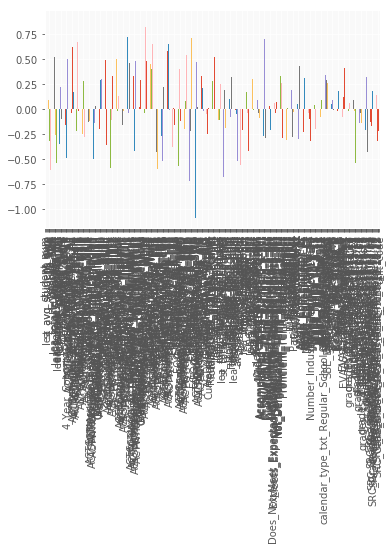

In [19]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=dfPublicHS.columns)
weights.plot(kind='bar')
plt.show()

## Create Models (50 points)
<span style="color: blue">Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate.</b> If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

## Model Advantages (10 points)
<span style="color: blue">Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</span>

## Interpret Feature Importance (30 points)

<span style="color: blue">Use the weights from logistic regression to interpret the importance of different features for the classification task. <b>Explain your interpretation in detail.</b>Why do you think some variables are more important?

## Interpret Support Vectors (10 points)
<span style="color:blue">Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.